In [65]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import pickle
import random

path = os.getcwd().split(os.sep + 'GUI')[0]
if path not in sys.path:
    print("not here")
    sys.path.append(path)

from neurolib.models.aln import ALNModel
from neurolib.utils import plotFunctions as plotFunc
from neurolib.utils import costFunctions as cost
import neurolib.dashboard.functions as functions
import neurolib.dashboard.data as data
    
# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2 

#path = os.path.join(os.getcwd(), "plots")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [66]:
grid_data_file = os.path.join(os.getcwd().split('data')[0], 'bi.pickle')
print(grid_data_file)
with open(grid_data_file,'rb') as f:
    load_array= pickle.load(f)
exc = load_array[0]
inh = load_array[1]
print(len(exc))

/home/lena/Promotion/neurolib/GUI/current/gui/bi.pickle
147


In [67]:
aln = ALNModel()
N = aln.params.N

data.set_parameters(aln)

state_vars = aln.state_vars
init_vars = aln.init_vars

##############################################################
def setinit(init_vars_, model):
    state_vars = model.state_vars
    init_vars = model.init_vars
    for iv in range(len(init_vars)):
        for sv in range(len(state_vars)):
            if state_vars[sv] in init_vars[iv]:
                #print("set init vars ", )
                if model.params[init_vars[iv]].ndim == 2:
                    model.params[init_vars[iv]][0,:] = init_vars_[sv]
                else:
                    model.params[init_vars[iv]][0] = init_vars_[sv]
                    
##############################################################               
def setmaxmincontrol(max_c_c, min_c_c, max_c_r, min_c_r):
    import numpy as np
    
    max_cntrl = np.zeros(( 6 ))
    min_cntrl = np.zeros(( 6 ))
    
    max_cntrl[0] = max_c_c
    min_cntrl[0] = min_c_c
    max_cntrl[1] = max_c_c
    min_cntrl[1] = min_c_c
    max_cntrl[2] = max_c_r
    min_cntrl[2] = min_c_r
    max_cntrl[3] = max_c_r
    min_cntrl[3] = min_c_r
    max_cntrl[4] = max_c_r
    min_cntrl[4] = min_c_r
    max_cntrl[5] = max_c_r
    min_cntrl[5] = min_c_r
            
    return max_cntrl, min_cntrl

In [68]:
dur = 500.
t_pen = 0.96

In [69]:
file_ = '3_m.pickle'
folder = str(os.getcwd().split('data_2')[1])
print(folder)
case = str(folder[1])

/3


In [70]:
dur_pre = 10
dur_post = 10

n_pre = int(np.around(dur_pre/aln.params.dt + 1.,1))
n_post = int(np.around(dur_post/aln.params.dt + 1.,1))

tol = 1e-10
start_step = 10.
c_scheme = np.zeros(( 1,1 ))
c_scheme[0,0] = 1.
u_mat = np.identity(1)
u_scheme = np.array([[1.]])

p_var = [0]
c_var = [0]
wp = 1. / (dur - t_pen * dur)

if case in ['1', '2']:    # low to high
    max_I = [3., -3.]
else:
    max_I = [-3., 3.]
    
if case in ['1', '3']:    # sparsity
    factor_ws = 1.
    factor_we = 0.
else:
    factor_ws = 0.
    factor_we = 1.
    
ind_cost = 2
if case in ['2', '4']:
    ind_cost = 1
    
maxC = [5., -5., 0.18, 0.]
max_cntrl, min_cntrl = setmaxmincontrol(maxC[0], maxC[1], maxC[2], maxC[3])

In [71]:
bestControl_ = [None] * len(exc) 
bestState_ = [None] * len(exc) 
cost_ = [None] * len(exc) 
costnode_ = [None] * len(exc) 
weights_ = [None] * len(exc) 

if os.path.isfile(file_) :
    print("file found")
    
    with open(file_,'rb') as f:
        load_array = pickle.load(f)

    bestControl_ = load_array[0]
    bestState_ = load_array[1]
    cost_ = load_array[2]
    costnode_ = load_array[3]
    weights_ = load_array[4]

file found


In [72]:
initVars = [None] * len(exc)
target = [None] * len(exc)
cost_uncontrolled = [None] * len(exc)

In [73]:
# get initial parameters and target states

i_range = [20,50]

data.set_parameters(aln)

for i in i_range:
    print("------- ", i, exc[i], inh[i])
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.
    
    aln.params.duration = 3000.
    
    control0 = aln.getZeroControl()
    control0 = functions.step_control(aln, maxI_ = max_I[0])

    aln.run(control=control0)
    
    target_rates = np.zeros((2))
    target_rates[0] = aln.rates_exc[0,-1] 
    target_rates[1] = aln.rates_inh[0,-1]

    control0 = functions.step_control(aln, maxI_ = max_I[1])
    aln.run(control=control0)

    init_state_vars = np.zeros(( len(state_vars) ))
    for j in range(len(state_vars)):
        if aln.state[state_vars[j]].size == 1:
            init_state_vars[j] = aln.state[state_vars[j]][0]
        else:
            init_state_vars[j] = aln.state[state_vars[j]][0,-1]

    initVars[i] = init_state_vars
    target[i] = [target_rates[0], target_rates[1]]

-------  20 0.4500000000000001 0.4750000000000002
-------  50 0.47500000000000014 0.6000000000000003


In [74]:
# get uncontrolled cost
data.set_parameters(aln)

for i in i_range:
    print("------- ", i, exc[i], inh[i])
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.
    
    aln.params.duration = dur
    
    target_ = aln.getZeroTarget()
    target_[:,0,:] = target[i][0]
    target_[:,1,:] = target[i][1]
            
    cost.setParams(wp, 0.0, 0.0)

    setinit(initVars[i], aln)
    control0 = aln.getZeroControl()

    cgv = None
    max_it = 0

    bestControl_init_, bestState_init_, cost_init_, runtime_init_, grad_init_, phi_init_, phi1_, costnode_init_ = aln.A1(
        control0, target_, c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
        startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
        t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = c_var,
        prec_variables_ = p_var, transition_time_ = t_pen)
    
    cost_uncontrolled[i] = cost_init_[0]

-------  20 0.4500000000000001 0.4750000000000002
set cost params:  0.05 0.0 0.0
interpolate adjoint :  True True True
initial cost =  636.9058225135838
RUN  0 , total integrated cost =  636.9058225135838
Gradient descend method:  None
RUN  0 , total integrated cost =  636.9058225135838
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
-------  50 0.47500000000000014 0.6000000000000003
set cost params:  0.05 0.0 0.0
interpolate adjoint :  True True True
initial cost =  797.1477718037709
RUN  0 , total integrated cost =  797.1477718037709
Gradient descend method:  None
RUN  0 , total integrated cost =  797.1477718037709
Improved over  0  iterations in  0.0  seconds by  0.0  percent.


In [53]:
file_ = '3_m.pickle'

bestControl_ = [None] * len(exc) 
bestState_ = [None] * len(exc) 
cost_ = [None] * len(exc) 
costnode_ = [None] * len(exc) 
weights_ = [None] * len(exc) 

if os.path.isfile(file_) :
    print("file found")
    
    with open(file_,'rb') as f:
        load_array = pickle.load(f)

    bestControl_ = load_array[0]
    bestState_ = load_array[1]
    cost_ = load_array[2]
    costnode_ = load_array[3]
    weights_ = load_array[4]

file found


-------  20 0.4500000000000001 0.4750000000000002
set cost params:  0.05 0.0 10.0
interpolate adjoint :  True True True
initial cost =  154.9193338482974
RUN  0 , total integrated cost =  154.9193338482974
Gradient descend method:  None
RUN  0 , total integrated cost =  154.9193338482974
Improved over  0  iterations in  0.0  seconds by  0.0  percent.


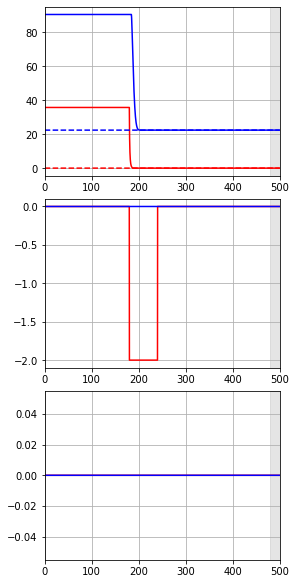

uncontrolled cost :  636.9058225135838
cost splitting :  3.822090229032632e-14 [15.49193338  0.        ]
-------  50 0.47500000000000014 0.6000000000000003
set cost params:  0.05 0.0 10.0
interpolate adjoint :  True True True
initial cost =  154.9193338482974
RUN  0 , total integrated cost =  154.9193338482974
Gradient descend method:  None
RUN  0 , total integrated cost =  154.9193338482974
Improved over  0  iterations in  0.0  seconds by  0.0  percent.


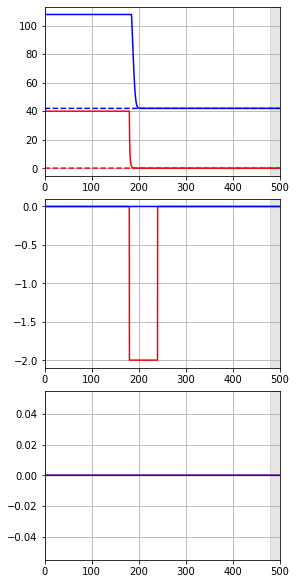

uncontrolled cost :  797.1477718037709
cost splitting :  7.426619449515177e-18 [15.49193338  0.        ]


In [17]:
cgv = None
j = 0

for i in i_range:
    print("------- ", i, exc[i], inh[i])
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.
    
    aln.params.duration = dur
    setinit(initVars[i], aln)

    target_ = aln.getZeroTarget()
    target_[:,0,:] = target[i][0]
    target_[:,1,:] = target[i][1]

    control0 = aln.getZeroControl()
    cost.setParams(wp, 0., 10.)
    max_it = int(0)

    if i == 20:
        control0[0,0,1800:2400] = -2.
        c_var = [1]
    if i == 50:
        control0[0,0,1800:2400] = -2.
        c_var = [0]

    bestControl_[i], bestState_[i], cost_[i], runtime_, grad_, phi_, phi1_, costnode_[i] = aln.A1(
        control0, target_, c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
        startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
        t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = c_var,
        prec_variables_ = p_var, transition_time_ = t_pen)

    if True:
        plot_time_array = np.arange(0.,round(dur+aln.params.dt,1),aln.params.dt)
        target_ = aln.getZeroTarget()
        target_[:,0,:] = target[i][0]
        target_[:,1,:] = target[i][1]

        fig, ax = plt.subplots(3,1, constrained_layout=True, figsize = (4,8) )
        ax[1].plot(plot_time_array, bestControl_[i][0,0,n_pre-1:-n_post+1], color = 'red')
        ax[0].plot(plot_time_array, bestState_[i][0,0,n_pre-1:-n_post+1], color= 'red')
        ax[1].plot(plot_time_array, bestControl_[i][0,1,n_pre-1:-n_post+1], color = 'blue')
        ax[0].plot(plot_time_array, bestState_[i][0,1,n_pre-1:-n_post+1], color= 'blue')
        ax[0].plot(plot_time_array, target_[0,0,n_pre-1:-n_post+1], linestyle = '--', color='red')
        ax[0].plot(plot_time_array, target_[0,1,n_pre-1:-n_post+1], linestyle = '--', color='blue')


        ax[2].plot(plot_time_array, phi_[0,0,:], color = 'red')
        ax[2].plot(plot_time_array, phi_[0,1,:], color = 'blue')
        for k in range(3):
            ax[k].set_xlim(0.,dur)
            ax[k].axvspan(dur*t_pen, dur, alpha=0.2, color='gray')
        plt.show()

    print('uncontrolled cost : ', cost_uncontrolled[i])
    print('cost splitting : ', costnode_[i][0][0][0], costnode_[i][ind_cost][0][:2])    

-------  20 0.4500000000000001 0.4750000000000002
-------  50 0.47500000000000014 0.6000000000000003
set cost params:  0.05 0.0 233.47108311781653
interpolate adjoint :  True True True
initial cost =  620.3290231124973
RUN  0 , total integrated cost =  620.3290231124973
Gradient descend method:  None
RUN  1 , total integrated cost =  620.3290231124378
RUN  2 , total integrated cost =  620.3290231124375
RUN  3 , total integrated cost =  620.3290231124367
RUN  4 , total integrated cost =  620.3290231124367
Control only changes marginally.
RUN  4 , total integrated cost =  620.3290231124367
Improved over  4  iterations in  4.4860345219494775  seconds by  9.777068044058979e-12  percent.
cost splitting :  6.385935258889427e-08 [2.65698439 0.        ]
set cost params:  0.05 0.0 272.16028807050833
interpolate adjoint :  True True True
initial cost =  723.1256366916245
RUN  0 , total integrated cost =  723.1256366916245
Gradient descend method:  None
RUN  1 , total integrated cost =  723.12563

RUN  1 , total integrated cost =  212.69377772145896
RUN  2 , total integrated cost =  212.69377772145882
RUN  3 , total integrated cost =  212.6937777214587
RUN  4 , total integrated cost =  212.69377772145822
RUN  5 , total integrated cost =  212.69377772145813
RUN  6 , total integrated cost =  212.69377772145793
RUN  7 , total integrated cost =  212.69377772145768
RUN  8 , total integrated cost =  212.69377772145748
RUN  9 , total integrated cost =  212.69377772145742
RUN  10 , total integrated cost =  212.6937777214571
RUN  11 , total integrated cost =  212.6937777214569
RUN  12 , total integrated cost =  212.69377772145663
RUN  13 , total integrated cost =  212.69377772145606
RUN  14 , total integrated cost =  212.69377772144887
RUN  15 , total integrated cost =  212.69377772144296
RUN  16 , total integrated cost =  212.69377772144182
RUN  17 , total integrated cost =  212.6937777214402
RUN  18 , total integrated cost =  212.6937777214402
Control only changes marginally.
RUN  18 ,

RUN  1 , total integrated cost =  480.8549194934589
RUN  2 , total integrated cost =  480.8549194934564
RUN  3 , total integrated cost =  480.85491949345555
RUN  4 , total integrated cost =  480.85491949345516
RUN  5 , total integrated cost =  480.85491949345453
RUN  6 , total integrated cost =  480.8549194934543
RUN  7 , total integrated cost =  480.8549194934536
RUN  8 , total integrated cost =  480.85491949345317
RUN  9 , total integrated cost =  480.8549194934528
RUN  10 , total integrated cost =  480.8549194934521
RUN  11 , total integrated cost =  480.8549194934518
RUN  12 , total integrated cost =  480.8549194934507
RUN  13 , total integrated cost =  480.85491949344924
RUN  14 , total integrated cost =  480.85491949344896
RUN  15 , total integrated cost =  480.8549194934484
RUN  16 , total integrated cost =  480.8549194934482
RUN  17 , total integrated cost =  480.8549194934479
RUN  18 , total integrated cost =  480.8549194934476
RUN  19 , total integrated cost =  480.8549194934

RUN  1 , total integrated cost =  159.96416007937665
RUN  2 , total integrated cost =  159.96416007937623
RUN  3 , total integrated cost =  159.96416007937617
RUN  4 , total integrated cost =  159.96416007937617
Control only changes marginally.
RUN  4 , total integrated cost =  159.96416007937617
Improved over  4  iterations in  3.3786080529680476  seconds by  1.9628032532637008e-10  percent.
cost splitting :  2.431474190376445e-08 [2.65691193 0.        ]
set cost params:  0.05 0.0 196.03533503593226
interpolate adjoint :  True True True
initial cost =  520.8486207357438
RUN  0 , total integrated cost =  520.8486207357438
Gradient descend method:  None
RUN  1 , total integrated cost =  520.8486207344876
RUN  2 , total integrated cost =  520.8486207344876
Control only changes marginally.
RUN  2 , total integrated cost =  520.8486207344876
Improved over  2  iterations in  2.0511317359050736  seconds by  2.412008370811236e-10  percent.
cost splitting :  5.581449445676612e-08 [2.65691193 0

RUN  2 , total integrated cost =  147.71846411560608
RUN  3 , total integrated cost =  147.71846411560608
Control only changes marginally.
RUN  3 , total integrated cost =  147.71846411560608
Improved over  3  iterations in  1.8814734590705484  seconds by  1.0831797681021271e-09  percent.
cost splitting :  2.2940000781868895e-08 [2.65691193 0.        ]
set cost params:  0.05 0.0 103.79738619886311
interpolate adjoint :  True True True
initial cost =  275.7805138949216
RUN  0 , total integrated cost =  275.7805138949216
Gradient descend method:  None
RUN  1 , total integrated cost =  275.7805138946845
RUN  2 , total integrated cost =  275.7805138946845
Control only changes marginally.
RUN  2 , total integrated cost =  275.7805138946845
Improved over  2  iterations in  1.2478016309905797  seconds by  8.600409273640253e-11  percent.
cost splitting :  3.663558928274009e-08 [2.65691193 0.        ]
set cost params:  0.05 0.0 89.20803175572192
interpolate adjoint :  True True True
initial cos

RUN  1 , total integrated cost =  90.95967570439997
RUN  2 , total integrated cost =  90.95967570439953
RUN  3 , total integrated cost =  90.95967570439953
Control only changes marginally.
RUN  3 , total integrated cost =  90.95967570439953
Improved over  3  iterations in  2.172131050028838  seconds by  6.059650559109286e-10  percent.
cost splitting :  1.7197528139012507e-08 [2.65691193 0.        ]
set cost params:  0.05 0.0 263.0926887001653
interpolate adjoint :  True True True
initial cost =  699.0141038106784
RUN  0 , total integrated cost =  699.0141038106784
Gradient descend method:  None
RUN  1 , total integrated cost =  699.0141038066789
RUN  2 , total integrated cost =  699.0141038066702
RUN  3 , total integrated cost =  699.0141038066655
RUN  4 , total integrated cost =  699.0141038066623
RUN  5 , total integrated cost =  699.0141038066623
Control only changes marginally.
RUN  5 , total integrated cost =  699.0141038066623
Improved over  5  iterations in  3.544090286944993  s

RUN  1 , total integrated cost =  174.16193313358164
RUN  2 , total integrated cost =  174.16193313358164
Control only changes marginally.
RUN  2 , total integrated cost =  174.16193313358164
Improved over  2  iterations in  2.0683025550097227  seconds by  1.7479351299698465e-11  percent.
cost splitting :  2.593145484732213e-08 [2.65691193 0.        ]
set cost params:  0.05 0.0 218.25170114415127
interpolate adjoint :  True True True
initial cost =  579.8755489322128
RUN  0 , total integrated cost =  579.8755489322128
Gradient descend method:  None
RUN  1 , total integrated cost =  579.8755489308237
RUN  2 , total integrated cost =  579.8755489308229
RUN  3 , total integrated cost =  579.8755489308224
RUN  4 , total integrated cost =  579.8755489308224
Control only changes marginally.
RUN  4 , total integrated cost =  579.8755489308224
Improved over  4  iterations in  3.7214411759050563  seconds by  2.397797516096034e-10  percent.
cost splitting :  6.03036503451021e-08 [2.65691193 0.  

RUN  1 , total integrated cost =  712.0364072062754
RUN  2 , total integrated cost =  712.0364072062731
RUN  3 , total integrated cost =  712.0364072062672
RUN  4 , total integrated cost =  712.036407206267
RUN  5 , total integrated cost =  712.0364072062665
RUN  6 , total integrated cost =  712.0364072062654
RUN  7 , total integrated cost =  712.036407206263
RUN  8 , total integrated cost =  712.036407206263
Control only changes marginally.
RUN  8 , total integrated cost =  712.036407206263
Improved over  8  iterations in  5.881305994000286  seconds by  1.8047785488306545e-12  percent.
cost splitting :  6.992149693058463e-08 [2.65691193 0.        ]
set cost params:  0.05 0.0 77.98405120431083
interpolate adjoint :  True True True
initial cost =  207.196756146052
RUN  0 , total integrated cost =  207.196756146052
Gradient descend method:  None
RUN  1 , total integrated cost =  207.19675614510467
RUN  2 , total integrated cost =  207.19675614510416
RUN  3 , total integrated cost =  207.

RUN  1 , total integrated cost =  339.7722741027709
RUN  2 , total integrated cost =  339.7722741027709
Control only changes marginally.
RUN  2 , total integrated cost =  339.7722741027709
Improved over  2  iterations in  2.2862215540371835  seconds by  3.461323672127037e-09  percent.
cost splitting :  4.2591976804015136e-08 [2.65691193 0.        ]
set cost params:  0.05 0.0 209.10101060555925
interpolate adjoint :  True True True
initial cost =  555.5629700536631
RUN  0 , total integrated cost =  555.5629700536631
Gradient descend method:  None
RUN  1 , total integrated cost =  555.5629700534508
RUN  2 , total integrated cost =  555.5629700534504
RUN  3 , total integrated cost =  555.5629700534499
RUN  4 , total integrated cost =  555.5629700534499
Control only changes marginally.
RUN  4 , total integrated cost =  555.5629700534499
Improved over  4  iterations in  3.133885201998055  seconds by  3.836930773104541e-11  percent.
cost splitting :  5.7933549949574583e-08 [2.65691193 0.    

RUN  1 , total integrated cost =  527.2165276379894
Control only changes marginally.
RUN  1 , total integrated cost =  527.2165276379894
Improved over  1  iterations in  0.7722313010599464  seconds by  0.0  percent.
cost splitting :  5.5751021587337586e-08 [2.65691193 0.        ]


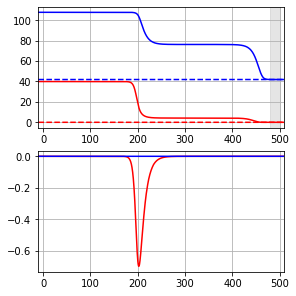

In [58]:
c_var = [0,1]
conv = [None] * len(exc)
max_it = int(100)

tol = 1e-14

for i in i_range:
    print("------- ", i, exc[i], inh[i])
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.
    
    if i == 20:
        continue
    
    while not conv[i]:

        weight_ = random.random() * ( cost_uncontrolled[i] -
                                     costnode_[i][0][0][0] ) / sum( costnode_[i][ind_cost][0][:] )
            
        aln.params.duration = dur
        cost.setParams(wp, weight_ * factor_we, weight_ * factor_ws)
        weights_[i] = cost.getParams()

        setinit(initVars[i], aln)

        target_ = aln.getZeroTarget()
        target_[:,0,:] = target[i][0]
        target_[:,1,:] = target[i][1]

        control0 = aln.getZeroControl()
        control0 = bestControl_[i][:,:,n_pre-1:-n_post+1]

        bestControl_[i], bestState_[i], cost_[i], runtime_, grad_, phi_, phi1_, costnode_[i] = aln.A1(
            control0, target_, c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
            startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
            t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = c_var,
            prec_variables_ = p_var, transition_time_ = t_pen)
        
        if cost_[i][2] == 0.:
            conv[i] = True

        print('cost splitting : ', costnode_[i][0][0][0], costnode_[i][ind_cost][0][:2])

        if conv[i]:
            time_ = np.arange(-dur_pre,round(dur+dur_post+aln.params.dt,1),aln.params.dt)
            target_ = aln.getZeroTarget()
            target_[:,0,:] = target[i][0]
            target_[:,1,:] = target[i][1]
        
            fig, ax = plt.subplots(2,1, constrained_layout=True, figsize = (4,4) )
            ax[1].plot(time_, bestControl_[i][0,0,:], color = 'red')
            ax[0].plot(time_, bestState_[i][0,0,:], color= 'red')
            ax[1].plot(time_, bestControl_[i][0,1,:], color = 'blue')
            ax[0].plot(time_, bestState_[i][0,1,:], color= 'blue')
            ax[0].plot(time_, target_[0,0,:], linestyle = '--', color='red')
            ax[0].plot(time_, target_[0,1,:], linestyle = '--', color='blue')
            ax[0].set_xlim(-dur_pre,dur+dur_post)
            ax[1].set_xlim(-dur_pre,dur+dur_post)
            ax[0].axvspan(dur*t_pen, dur, alpha=0.2, color='gray')
            plt.show()

        with open(file_,'wb') as f:
            pickle.dump([bestControl_, bestState_, cost_, costnode_, weights_], f)
        
        k += 1

-------  20 0.4500000000000001 0.4750000000000002


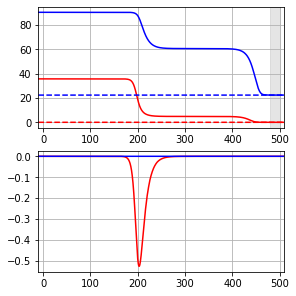

-------  50 0.47500000000000014 0.6000000000000003


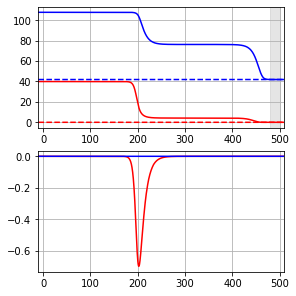

In [59]:
for i in i_range:
    print("------- ", i, exc[i], inh[i])
    
    aln.params.duration = dur + dur_pre + dur_post

    time_ = np.arange(-dur_pre,round(dur+dur_post+aln.params.dt,1),aln.params.dt)
    target_ = aln.getZeroTarget()
    target_[:,0,:] = target[i][0]
    target_[:,1,:] = target[i][1]

    fig, ax = plt.subplots(2,1, constrained_layout=True, figsize = (4,4) )
    ax[1].plot(time_, bestControl_[i][0,0,:], color = 'red')
    ax[0].plot(time_, bestState_[i][0,0,:], color= 'red')
    ax[1].plot(time_, bestControl_[i][0,1,:], color = 'blue')
    ax[0].plot(time_, bestState_[i][0,1,:], color= 'blue')
    ax[0].plot(time_, target_[0,0,:], linestyle = '--', color='red')
    ax[0].plot(time_, target_[0,1,:], linestyle = '--', color='blue')
    ax[0].set_xlim(-dur_pre,dur+dur_post)
    ax[1].set_xlim(-dur_pre,dur+dur_post)
    ax[0].axvspan(dur*t_pen, dur, alpha=0.2, color='gray')
    plt.show()

In [75]:
file_ = '3_p.pickle'

bestControl_ = [None] * len(exc) 
bestState_ = [None] * len(exc) 
cost_ = [None] * len(exc) 
costnode_ = [None] * len(exc) 
weights_ = [None] * len(exc) 

if os.path.isfile(file_) :
    print("file found")
    
    with open(file_,'rb') as f:
        load_array = pickle.load(f)

    bestControl_ = load_array[0]
    bestState_ = load_array[1]
    cost_ = load_array[2]
    costnode_ = load_array[3]
    weights_ = load_array[4]

file found


-------  20 0.4500000000000001 0.4750000000000002
set cost params:  0.05 0.0 10.0
interpolate adjoint :  True True True
initial cost =  154.91933384830105
RUN  0 , total integrated cost =  154.91933384830105
Gradient descend method:  None
RUN  1 , total integrated cost =  154.91933384830105
Control only changes marginally.
RUN  1 , total integrated cost =  154.91933384830105
Improved over  1  iterations in  0.20214237598702312  seconds by  0.0  percent.


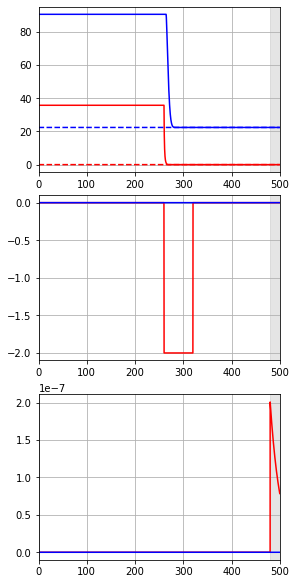

uncontrolled cost :  636.9058225135838
cost splitting :  7.272356286484067e-11 [15.49193338  0.        ]
-------  50 0.47500000000000014 0.6000000000000003
set cost params:  0.05 0.0 10.0
interpolate adjoint :  True True True
initial cost =  154.9193338482974
RUN  0 , total integrated cost =  154.9193338482974
Gradient descend method:  None
RUN  1 , total integrated cost =  36.16933384829714
RUN  2 , total integrated cost =  31.872458848297047
RUN  3 , total integrated cost =  31.799216660797477
RUN  4 , total integrated cost =  31.79826298648469
RUN  5 , total integrated cost =  31.798173585935913
RUN  6 , total integrated cost =  31.79817200221943
RUN  7 , total integrated cost =  31.798171740410535
RUN  8 , total integrated cost =  31.798169446994144
RUN  9 , total integrated cost =  31.798169373542123
RUN  10 , total integrated cost =  31.79816927567913
RUN  10 , total integrated cost =  31.79816927567913
Improved over  10  iterations in  1.9529297900153324  seconds by  79.47436999

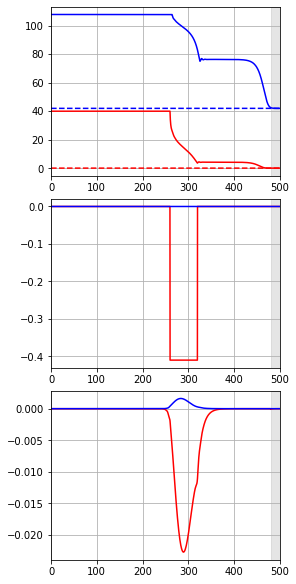

uncontrolled cost :  797.1477718037709
cost splitting :  6.2076424764114725e-06 [3.1798169 0.       ]


In [26]:
cgv = None
j = 0

for i in i_range:
    print("------- ", i, exc[i], inh[i])
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.
    
    aln.params.duration = dur
    setinit(initVars[i], aln)

    target_ = aln.getZeroTarget()
    target_[:,0,:] = target[i][0]
    target_[:,1,:] = target[i][1]

    control0 = aln.getZeroControl()
    cost.setParams(wp, 0., 10.)
    max_it = int(10)

    if i == 20:
        control0[0,0,2600:3200] = -2.
        c_var = [1]
    if i == 50:
        control0[0,0,2600:3200] = -2.
        c_var = [0]

    bestControl_[i], bestState_[i], cost_[i], runtime_, grad_, phi_, phi1_, costnode_[i] = aln.A1(
        control0, target_, c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
        startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
        t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = c_var,
        prec_variables_ = p_var, transition_time_ = t_pen)

    if True:
        plot_time_array = np.arange(0.,round(dur+aln.params.dt,1),aln.params.dt)
        target_ = aln.getZeroTarget()
        target_[:,0,:] = target[i][0]
        target_[:,1,:] = target[i][1]

        fig, ax = plt.subplots(3,1, constrained_layout=True, figsize = (4,8) )
        ax[1].plot(plot_time_array, bestControl_[i][0,0,n_pre-1:-n_post+1], color = 'red')
        ax[0].plot(plot_time_array, bestState_[i][0,0,n_pre-1:-n_post+1], color= 'red')
        ax[1].plot(plot_time_array, bestControl_[i][0,1,n_pre-1:-n_post+1], color = 'blue')
        ax[0].plot(plot_time_array, bestState_[i][0,1,n_pre-1:-n_post+1], color= 'blue')
        ax[0].plot(plot_time_array, target_[0,0,n_pre-1:-n_post+1], linestyle = '--', color='red')
        ax[0].plot(plot_time_array, target_[0,1,n_pre-1:-n_post+1], linestyle = '--', color='blue')


        ax[2].plot(plot_time_array, phi_[0,0,:], color = 'red')
        ax[2].plot(plot_time_array, phi_[0,1,:], color = 'blue')
        for k in range(3):
            ax[k].set_xlim(0.,dur)
            ax[k].axvspan(dur*t_pen, dur, alpha=0.2, color='gray')
        plt.show()

    print('uncontrolled cost : ', cost_uncontrolled[i])
    print('cost splitting : ', costnode_[i][0][0][0], costnode_[i][2][0][:2])    

In [77]:
c_var = [0,1]
conv = [None] * len(exc)
max_it = int(60)

tol = 1e-13

for i in i_range:
    print("------- ", i, exc[i], inh[i])
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.

    if i == 50:
        continue
    
    while not conv[i]:

        weight_ = random.random() * ( cost_uncontrolled[i] -
                                     costnode_[i][0][0][0] ) / sum( costnode_[i][2][0][:] )
            
        aln.params.duration = dur
        cost.setParams(wp, weight_ * factor_we, weight_ * factor_ws)
        weights_[i] = cost.getParams()

        setinit(initVars[i], aln)

        target_ = aln.getZeroTarget()
        target_[:,0,:] = target[i][0]
        target_[:,1,:] = target[i][1]

        control0 = aln.getZeroControl()
        control0 = bestControl_[i][:,:,n_pre-1:-n_post+1]

        bestControl_[i], bestState_[i], cost_[i], runtime_, grad_, phi_, phi1_, costnode_[i] = aln.A1(
            control0, target_, c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
            startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
            t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = c_var,
            prec_variables_ = p_var, transition_time_ = t_pen)
        
        if cost_[i][2] == 0.:
            conv[i] = True

        print('cost splitting : ', costnode_[i][0][0][0], costnode_[i][2][0][:2])

        if conv[i]:
            time_ = np.arange(-dur_pre,round(dur+dur_post+aln.params.dt,1),aln.params.dt)
            target_ = aln.getZeroTarget()
            target_[:,0,:] = target[i][0]
            target_[:,1,:] = target[i][1]
        
            fig, ax = plt.subplots(2,1, constrained_layout=True, figsize = (4,4) )
            ax[1].plot(time_, bestControl_[i][0,0,:], color = 'red')
            ax[0].plot(time_, bestState_[i][0,0,:], color= 'red')
            ax[1].plot(time_, bestControl_[i][0,1,:], color = 'blue')
            ax[0].plot(time_, bestState_[i][0,1,:], color= 'blue')
            ax[0].plot(time_, target_[0,0,:], linestyle = '--', color='red')
            ax[0].plot(time_, target_[0,1,:], linestyle = '--', color='blue')
            ax[0].set_xlim(-dur_pre,dur+dur_post)
            ax[1].set_xlim(-dur_pre,dur+dur_post)
            ax[0].axvspan(dur*t_pen, dur, alpha=0.2, color='gray')
            plt.show()

        with open(file_,'wb') as f:
            pickle.dump([bestControl_, bestState_, cost_, costnode_, weights_], f)
        
        k += 1

-------  20 0.4500000000000001 0.4750000000000002
set cost params:  0.05 0.0 104.27907321224303
interpolate adjoint :  True True True
initial cost =  223.80198778275965
RUN  0 , total integrated cost =  223.80198778275965
Gradient descend method:  None
RUN  1 , total integrated cost =  223.8019877768675
RUN  2 , total integrated cost =  223.80198777685683
RUN  3 , total integrated cost =  223.80198777685675
RUN  4 , total integrated cost =  223.80198777685675
Control only changes marginally.
RUN  4 , total integrated cost =  223.80198777685675
Improved over  4  iterations in  3.7849167439853773  seconds by  2.6375630568509223e-09  percent.
cost splitting :  0.0001062483236152597 [2.14618308 0.        ]
set cost params:  0.05 0.0 115.60370195981639
interpolate adjoint :  True True True
initial cost =  248.10671437547353
RUN  0 , total integrated cost =  248.10671437547353
Gradient descend method:  None
RUN  1 , total integrated cost =  248.10671435449615
RUN  2 , total integrated cost =

KeyboardInterrupt: 

-------  20 0.4500000000000001 0.4750000000000002


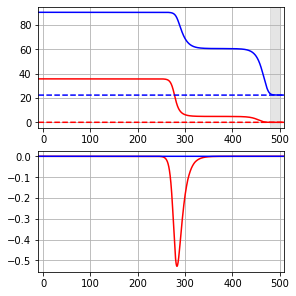

-------  50 0.47500000000000014 0.6000000000000003


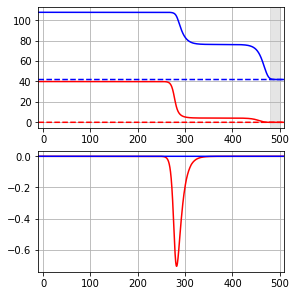

In [64]:
for i in i_range:
    print("------- ", i, exc[i], inh[i])
    
    aln.params.duration = dur + dur_pre + dur_post

    time_ = np.arange(-dur_pre,round(dur+dur_post+aln.params.dt,1),aln.params.dt)
    target_ = aln.getZeroTarget()
    target_[:,0,:] = target[i][0]
    target_[:,1,:] = target[i][1]

    fig, ax = plt.subplots(2,1, constrained_layout=True, figsize = (4,4) )
    ax[1].plot(time_, bestControl_[i][0,0,:], color = 'red')
    ax[0].plot(time_, bestState_[i][0,0,:], color= 'red')
    ax[1].plot(time_, bestControl_[i][0,1,:], color = 'blue')
    ax[0].plot(time_, bestState_[i][0,1,:], color= 'blue')
    ax[0].plot(time_, target_[0,0,:], linestyle = '--', color='red')
    ax[0].plot(time_, target_[0,1,:], linestyle = '--', color='blue')
    ax[0].set_xlim(-dur_pre,dur+dur_post)
    ax[1].set_xlim(-dur_pre,dur+dur_post)
    ax[0].axvspan(dur*t_pen, dur, alpha=0.2, color='gray')
    plt.show()